<a href="https://colab.research.google.com/github/beyzoskaya/timeSeries_HiC/blob/main/comparison_graph_models/ASTGCN_mirna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch_geometric

In [3]:
!pip install pandas scikit-learn scipy

In [4]:
import torch
print(torch.__version__)

2.6.0+cu124


In [5]:
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [6]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [7]:
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [8]:
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [9]:
!pip install torch-geometric -f https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [10]:
!pip install torch-geometric-temporal -f https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [11]:
!pip install torch_geometric

In [12]:
import torch_geometric_temporal.nn.attention as attn
print(dir(attn))

['AAGCN', 'ASTGCN', 'ChebConvAttention', 'DNNTSP', 'GMAN', 'GraphAAGCN', 'GraphConstructor', 'MSTGCN', 'MTGNN', 'MixProp', 'STConv', 'SpatioTemporalAttention', 'SpatioTemporalEmbedding', 'TemporalConv', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'astgcn', 'dnntsp', 'gman', 'mstgcn', 'mtgnn', 'stgcn', 'tsagcn']


In [13]:
from torch_geometric_temporal.nn.attention import ASTGCN

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn, optim
from torch_geometric_temporal.nn.attention import ASTGCN
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from scipy.stats import spearmanr, pearsonr

In [90]:
csv_path = '/content/gene_expression_over_time_mirna.csv'

df = pd.read_csv(csv_path)
df = df.drop(columns=['Time_154.0'], errors='ignore')
df.set_index('Gene', inplace=True)
print(f"Shape: {df.shape}")

data = df.values  # shape: (num_nodes, num_timepoints)
num_nodes, num_timepoints = data.shape

#scaler = StandardScaler()
#data = scaler.fit_transform(data.T).T

Shape: (162, 159)


In [91]:
data

array([[ 987. ,  421. ,  473. , ...,  444. , 1339. , 2732. ],
       [ 170.5,  100.5,   37.5, ...,   40.5,   48. ,  177.5],
       [  10. ,   12. ,    9. , ...,    5. ,   20. ,    6. ],
       ...,
       [   4. ,   13. ,   11. , ...,    9. ,   10. ,   16. ],
       [ 277.5,  131.5,   51. , ...,   32.5,   77. ,  493. ],
       [ 963. ,  342.5,  123. , ...,   22. ,   30.5,  298.5]])

In [92]:
print(df.columns)  # Confirm 'Time_154.0' is gone

Index(['Time_1.0', 'Time_2.0', 'Time_3.0', 'Time_4.0', 'Time_5.0', 'Time_6.0',
       'Time_7.0', 'Time_8.0', 'Time_9.0', 'Time_10.0',
       ...
       'Time_150.0', 'Time_151.0', 'Time_152.0', 'Time_153.0', 'Time_155.0',
       'Time_156.0', 'Time_157.0', 'Time_158.0', 'Time_159.0', 'Time_160.0'],
      dtype='object', length=159)


In [93]:
print(f"Data shape: {data.shape}")
print(f"Sample data (first 5 genes, first 5 time points):\n{data[:5, :5]}")

Data shape: (162, 159)
Sample data (first 5 genes, first 5 time points):
[[987.         421.         473.         830.         173.        ]
 [170.5        100.5         37.5         62.5        106.5       ]
 [ 10.          12.           9.           7.           8.        ]
 [  3.           2.          19.          10.          19.        ]
 [131.90697674  68.60465116  34.44186047  37.6627907   61.93023256]]


In [107]:
corr = np.corrcoef(data)
threshold = 0.4
adj = (np.abs(corr) > threshold).astype(float)
np.fill_diagonal(adj, 1)
print(adj)
# Convert to edge_index & edge_weight
edge_index = torch.tensor(np.array(np.nonzero(adj)), dtype=torch.long)
edge_weight = torch.tensor(adj[adj != 0], dtype=torch.float32)

print(f"Num edges: {edge_index.shape[1]}")

[[1. 1. 0. ... 0. 1. 1.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [1. 1. 0. ... 0. 1. 1.]]
Num edges: 15822


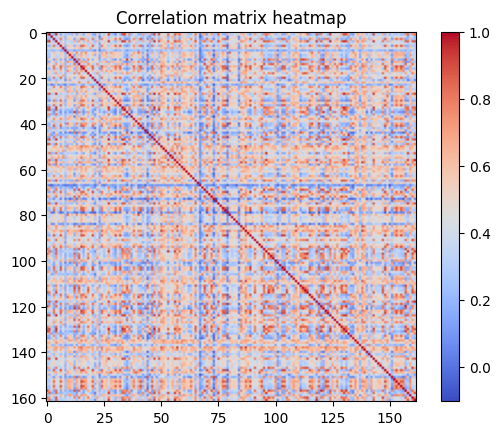

In [108]:
import matplotlib.pyplot as plt
plt.imshow(corr, cmap='coolwarm')
plt.colorbar()
plt.title("Correlation matrix heatmap")
plt.show()

In [109]:
seq_len = 5
pred_len = 1

features, targets = [], []

for t in range(num_timepoints - seq_len - pred_len):
    x = data[:, t:t+seq_len]                # (num_nodes, seq_len)
    print(f"x shape: {x.shape}")
    y = data[:, t+seq_len:t+seq_len+pred_len]  # (num_nodes, pred_len)
    print(f"y shape: {y.shape}")
    print(f"Example x: {x[0]}")
    print(f"Example y: {y[0]}")
    features.append(x[:, :, None])          # add feature dim: (num_nodes, seq_len, 1)
    targets.append(y)

print(f"Num samples: {len(features)}")

x shape: (162, 5)
y shape: (162, 1)
Example x: [987. 421. 473. 830. 173.]
Example y: [35.]
x shape: (162, 5)
y shape: (162, 1)
Example x: [421. 473. 830. 173.  35.]
Example y: [644.]
x shape: (162, 5)
y shape: (162, 1)
Example x: [473. 830. 173.  35. 644.]
Example y: [105.]
x shape: (162, 5)
y shape: (162, 1)
Example x: [830. 173.  35. 644. 105.]
Example y: [80.]
x shape: (162, 5)
y shape: (162, 1)
Example x: [173.  35. 644. 105.  80.]
Example y: [891.]
x shape: (162, 5)
y shape: (162, 1)
Example x: [ 35. 644. 105.  80. 891.]
Example y: [872.]
x shape: (162, 5)
y shape: (162, 1)
Example x: [644. 105.  80. 891. 872.]
Example y: [626.]
x shape: (162, 5)
y shape: (162, 1)
Example x: [105.  80. 891. 872. 626.]
Example y: [1957.]
x shape: (162, 5)
y shape: (162, 1)
Example x: [  80.  891.  872.  626. 1957.]
Example y: [1928.]
x shape: (162, 5)
y shape: (162, 1)
Example x: [ 891.  872.  626. 1957. 1928.]
Example y: [51.]
x shape: (162, 5)
y shape: (162, 1)
Example x: [ 872.  626. 1957. 1928.

In [110]:
edge_index

tensor([[  0,   0,   0,  ..., 161, 161, 161],
        [  0,   1,   4,  ..., 158, 160, 161]])

In [111]:
edge_index.shape

torch.Size([2, 15822])

In [112]:
dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=features,
    targets=targets
)

In [113]:
dataset

In [114]:
features

[array([[[9.87000000e+02],
         [4.21000000e+02],
         [4.73000000e+02],
         [8.30000000e+02],
         [1.73000000e+02]],
 
        [[1.70500000e+02],
         [1.00500000e+02],
         [3.75000000e+01],
         [6.25000000e+01],
         [1.06500000e+02]],
 
        [[1.00000000e+01],
         [1.20000000e+01],
         [9.00000000e+00],
         [7.00000000e+00],
         [8.00000000e+00]],
 
        [[3.00000000e+00],
         [2.00000000e+00],
         [1.90000000e+01],
         [1.00000000e+01],
         [1.90000000e+01]],
 
        [[1.31906977e+02],
         [6.86046512e+01],
         [3.44418605e+01],
         [3.76627907e+01],
         [6.19302326e+01]],
 
        [[1.00000000e+01],
         [1.20000000e+01],
         [1.20000000e+01],
         [1.00000000e+01],
         [7.00000000e+00]],
 
        [[1.30000000e+01],
         [1.40000000e+01],
         [2.30000000e+01],
         [1.80000000e+01],
         [3.60000000e+01]],
 
        [[9.00000000e+00],
       

In [115]:
train_size = int(0.8 * len(features))
train_dataset = list(dataset)[:train_size]
test_dataset = list(dataset)[train_size:]

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 122, Test samples: 31


In [116]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ASTGCN(
    nb_block=2,
    in_channels=1,
    K=3,
    nb_chev_filter=16,
    nb_time_filter=16,
    time_strides=1,
    num_for_predict=pred_len,
    len_input=seq_len,
    num_of_vertices=num_nodes
).to(device)

In [117]:
print("Adjacency matrix shape:", adj.shape)
print("Number of edges:", edge_index.shape[1])
print("Edge weights:", edge_weight)
print("Are there isolated nodes?")

# Degree of each node
degrees = adj.sum(axis=1)
print(degrees)

isolated_nodes = np.where(degrees == 0)[0]
print("Isolated nodes:", isolated_nodes)


Adjacency matrix shape: (162, 162)
Number of edges: 15822
Edge weights: tensor([1., 1., 1.,  ..., 1., 1., 1.])
Are there isolated nodes?
[ 95.  84.  62.  92. 109.  70.  94. 122.   1. 111.  96.  99.  69.  95.
 108. 118.  94. 127.  98. 117.  93.  32. 149.  15. 127. 100. 135.  97.
 111.  97.  81. 142.  94. 116.  76.  51.  83.  92. 133.  83.  95.  94.
  56.  93.  45.  65.  92. 100. 103.  80. 141. 148. 128.  75. 120. 136.
  84. 155.  71. 147. 114. 143.  90.  99. 146.  82. 110.   4.  66. 103.
  88. 142. 107.  34.  94.  83. 145. 103.  89.  31. 115.  93. 119. 112.
  32. 151. 136. 144. 101.  93.  96. 130.  78. 132. 108.  92.  76.  89.
  86. 103.  97.  49.  64.  96.  95.  92.  64. 109.  98. 143. 139.  80.
  92.  99. 110.  93.  99. 106.  89.  89.  85.  56. 123.  95. 102. 117.
 104. 141.  76.  86. 101.  83.  55.  93.  85. 142. 148.  49. 154. 153.
  96.  55.  97. 137. 108. 102. 103. 103.  95. 144.  54.  52. 102. 115.
 110.  98.  93.  84.  74.  98. 106.  90.]
Isolated nodes: []


In [118]:
print("Number of nonzero entries in adjacency:", np.count_nonzero(adj))
print("Sample adjacency (10x10):")
print(adj[:10, :10])

Number of nonzero entries in adjacency: 15822
Sample adjacency (10x10):
[[1. 1. 0. 0. 1. 1. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 1. 1. 1. 0. 1.]]


In [119]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

epochs = 20

for epoch in range(epochs):
    model.train()
    losses = []
    for snapshot in train_dataset:
        x = snapshot.x.clone().detach().float().unsqueeze(0).to(device)
        #print(f"x shape: {x.shape}")
        x = x.permute(0, 1, 3, 2)  # fix shape for ASTGCN
        #print(f"x shape after permute: {x.shape}")
        y = snapshot.y.clone().detach().float().to(device)
        #print(f"y shape: {y.shape}")

        edge_index = snapshot.edge_index.to(device)

        pred = model(x, edge_index)
        loss = criterion(pred.squeeze(0), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")


Epoch 1/20, Loss: 371385.0842
Epoch 2/20, Loss: 371118.3489
Epoch 3/20, Loss: 370824.9697
Epoch 4/20, Loss: 370554.3456
Epoch 5/20, Loss: 370263.2465
Epoch 6/20, Loss: 369888.0781
Epoch 7/20, Loss: 369561.8535
Epoch 8/20, Loss: 369269.5102
Epoch 9/20, Loss: 368986.5559
Epoch 10/20, Loss: 368706.5649
Epoch 11/20, Loss: 368426.2753
Epoch 12/20, Loss: 368146.2008
Epoch 13/20, Loss: 367868.1519
Epoch 14/20, Loss: 367591.9964
Epoch 15/20, Loss: 367317.3457
Epoch 16/20, Loss: 367043.1090
Epoch 17/20, Loss: 366768.4792
Epoch 18/20, Loss: 366493.3483
Epoch 19/20, Loss: 366217.7127
Epoch 20/20, Loss: 365941.5618


Per gene / temporal accuracy as mean pearson and spearman

In [120]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error
import numpy as np

model.eval()

all_preds = []   # store predictions over all test snapshots
all_targets = [] # store true values over all test snapshots

with torch.no_grad():
    for snapshot in test_dataset:
        x = snapshot.x.clone().detach().float().unsqueeze(0).to(device)
        x = x.permute(0, 1, 3, 2)  # fix shape for ASTGCN

        edge_index = snapshot.edge_index.to(device)

        pred = model(x, edge_index).squeeze(0).cpu().numpy()  # shape: (num_nodes, pred_len)
        true = snapshot.y.clone().detach().cpu().numpy()      # shape: (num_nodes, pred_len)

        # squeeze pred_len if =1
        pred = pred.squeeze(-1)  # shape: (num_nodes,)
        true = true.squeeze(-1)

        all_preds.append(pred)     # shape: (num_nodes,)
        all_targets.append(true)

# Convert to numpy arrays: shape (num_snapshots, num_nodes)
all_preds = np.stack(all_preds, axis=0)     # (num_snapshots, num_nodes)
all_targets = np.stack(all_targets, axis=0)

print(f"all_preds shape: {all_preds.shape}")
print(f"all_targets shape: {all_targets.shape}")

num_nodes = all_preds.shape[1]
num_snapshots = all_preds.shape[0]

gene_pearson = []
gene_spearman = []
gene_rmse = []

for gene_idx in range(num_nodes):
    pred_gene = all_preds[:, gene_idx]   # shape: (num_snapshots,)
    true_gene = all_targets[:, gene_idx]

    # Check for valid variance to avoid nan
    if np.std(pred_gene) > 1e-8 and np.std(true_gene) > 1e-8:
        try:
            p_corr, _ = pearsonr(pred_gene, true_gene)
        except:
            p_corr = np.nan
        try:
            s_corr, _ = spearmanr(pred_gene, true_gene)
        except:
            s_corr = np.nan
    else:
        p_corr = np.nan
        s_corr = np.nan

    rmse = np.sqrt(mean_squared_error(true_gene, pred_gene))

    gene_pearson.append(p_corr)
    gene_spearman.append(s_corr)
    gene_rmse.append(rmse)

# Aggregate ignoring NaNs
mean_pearson = np.nanmean(gene_pearson)
mean_spearman = np.nanmean(gene_spearman)
mean_rmse = np.nanmean(gene_rmse)

print(f"\n=== Temporal per-gene evaluation ===")
print(f"Mean Pearson over genes: {mean_pearson:.4f}")
print(f"Mean Spearman over genes: {mean_spearman:.4f}")
print(f"Mean RMSE over genes: {mean_rmse:.4f}")

print(f"Number of valid genes (non-nan): {np.sum(~np.isnan(gene_pearson))} / {num_nodes}")


all_preds shape: (31, 162)
all_targets shape: (31, 162)

=== Temporal per-gene evaluation ===
Mean Pearson over genes: -0.0001
Mean Spearman over genes: 0.0464
Mean RMSE over genes: 257.4765
Number of valid genes (non-nan): 162 / 162


In [ ]:
from scipy.stats import pearsonr, spearmanr
import numpy as np

model.eval()
pearson_scores = []
spearman_scores = []

with torch.no_grad():
    for snapshot in test_dataset:
        x = snapshot.x.clone().detach().float().unsqueeze(0).to(device)
        x = x.permute(0, 1, 3, 2)  # shape fix for ASTGCN
        y_true = snapshot.y.clone().detach().float().cpu().numpy()
        print(f"y_true shape: {y_true.shape}")

        edge_index = snapshot.edge_index.to(device)
        print(f"edge_index shape: {edge_index.shape}")

        y_pred = model(x, edge_index).squeeze(0).cpu().numpy()
        print(f"y_pred shape: {y_pred.shape}")

        print(f"Example y_true: {y_true[0]}")
        print(f"Example y_pred: {y_pred[0]}")

        y_true_flat = y_true.flatten()
        print(f"y_true_flat: {y_true_flat.shape}")
        y_pred_flat = y_pred.flatten()
        print(f"y_pred_flat: {y_pred_flat.shape}")

        try:
            p_corr, _ = pearsonr(y_true_flat, y_pred_flat)
        except:
            print("Nan in pearson")
            p_corr = np.nan
        try:
            s_corr, _ = spearmanr(y_true_flat, y_pred_flat)
        except:
            print("Nan in spearman")
            s_corr = np.nan

        pearson_scores.append(p_corr)
        spearman_scores.append(s_corr)

mean_pearson = np.nanmean(pearson_scores)
mean_spearman = np.nanmean(spearman_scores)

print(f"Mean Pearson correlation on test set: {mean_pearson:.4f}")
print(f"Mean Spearman correlation on test set: {mean_spearman:.4f}")

y_true shape: (162, 1)
edge_index shape: torch.Size([2, 25358])
y_pred shape: (162, 1)
Example y_true: [-0.47936702]
Example y_pred: [-0.15126792]
y_true_flat: (162,)
y_pred_flat: (162,)
y_true shape: (162, 1)
edge_index shape: torch.Size([2, 25358])
y_pred shape: (162, 1)
Example y_true: [-0.11166706]
Example y_pred: [-0.1301097]
y_true_flat: (162,)
y_pred_flat: (162,)
y_true shape: (162, 1)
edge_index shape: torch.Size([2, 25358])
y_pred shape: (162, 1)
Example y_true: [2.00047]
Example y_pred: [-0.11390302]
y_true_flat: (162,)
y_pred_flat: (162,)
y_true shape: (162, 1)
edge_index shape: torch.Size([2, 25358])
y_pred shape: (162, 1)
Example y_true: [-0.23138332]
Example y_pred: [0.11377835]
y_true_flat: (162,)
y_pred_flat: (162,)
y_true shape: (162, 1)
edge_index shape: torch.Size([2, 25358])
y_pred shape: (162, 1)
Example y_true: [-0.9610825]
Example y_pred: [-0.17348608]
y_true_flat: (162,)
y_pred_flat: (162,)
y_true shape: (162, 1)
edge_index shape: torch.Size([2, 25358])
y_pred s

mrna pred

In [ ]:
csv_path = '/content/gene_expression_over_time.csv'

df = pd.read_csv(csv_path)
df = df.drop(columns=['Time_154.0'], errors='ignore')
df.set_index('Gene', inplace=True)
print(f"Shape: {df.shape}")

data = df.values  # shape: (num_nodes, num_timepoints)
num_nodes, num_timepoints = data.shape

Shape: (50, 43)


In [ ]:
print(f"Data shape: {data.shape}")
print(f"Sample data (first 5 genes, first 5 time points):\n{data[:5, :5]}")

Data shape: (50, 43)
Sample data (first 5 genes, first 5 time points):
[[ 8.43285714  7.68325     7.5535      7.5965      8.3614    ]
 [ 9.04357143 12.12725    11.7425     12.381      12.381     ]
 [ 6.81751786  6.68440625  6.5048125   6.6175      6.406375  ]
 [ 4.92214286  5.762       6.0735      5.765       5.7526    ]
 [ 6.15665714  4.949375    5.43265     5.4099      5.65982   ]]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# data shape: (num_nodes, num_timepoints)
similarity = cosine_similarity(data)  # or use other similarity/distance metrics

k = 5  # number of neighbors

adj = np.zeros((num_nodes, num_nodes))

for i in range(num_nodes):
    # Get indices of top k neighbors excluding itself
    neighbors = np.argsort(similarity[i])[-(k+1):-1]
    adj[i, neighbors] = similarity[i, neighbors]

# Symmetrize adjacency
adj = np.maximum(adj, adj.T)

# Optional: normalize adjacency (row sum to 1)
adj = adj / (adj.sum(axis=1, keepdims=True) + 1e-10)

# Convert to edge_index and edge_weight
edge_index = torch.tensor(np.array(np.nonzero(adj)), dtype=torch.long)
edge_weight = torch.tensor(adj[adj != 0], dtype=torch.float32)

print(f"Num edges: {edge_index.shape[1]}")


Num edges: 397


In [ ]:
seq_len = 3
pred_len = 1

features, targets = [], []

for t in range(num_timepoints - seq_len - pred_len):
    x = data[:, t:t+seq_len]                # (num_nodes, seq_len)
    y = data[:, t+seq_len:t+seq_len+pred_len]  # (num_nodes, pred_len)
    features.append(x[:, :, None])          # add feature dim: (num_nodes, seq_len, 1)
    targets.append(y)

print(f"Num samples: {len(features)}")

Num samples: 39


In [ ]:
dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=features,
    targets=targets
)

In [ ]:
train_size = int(0.8 * len(features))
train_dataset = list(dataset)[:train_size]
test_dataset = list(dataset)[train_size:]

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 31, Test samples: 8


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ASTGCN(
    nb_block=2,
    in_channels=1,
    K=3,
    nb_chev_filter=2,
    nb_time_filter=2,
    time_strides=1,
    num_for_predict=pred_len,
    len_input=seq_len,
    num_of_vertices=num_nodes
).to(device)

In [ ]:
print("Adjacency matrix shape:", adj.shape)
print("Number of edges:", edge_index.shape[1])
print("Edge weights:", edge_weight)
print("Are there isolated nodes?")

# Degree of each node
degrees = adj.sum(axis=1)
print(degrees)

isolated_nodes = np.where(degrees == 0)[0]
print("Isolated nodes:", isolated_nodes)

Adjacency matrix shape: (50, 50)
Number of edges: 397
Edge weights: None
Are there isolated nodes?
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Isolated nodes: []


In [ ]:
print("Number of nonzero entries in adjacency:", np.count_nonzero(adj))
print("Sample adjacency (10x10):")
print(adj[:10, :10])

Number of nonzero entries in adjacency: 397
Sample adjacency (10x10):
[[0.         0.         0.11120115 0.         0.11106327 0.
  0.         0.         0.11116045 0.        ]
 [0.         0.         0.12501651 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.06668753 0.06665568 0.         0.         0.06663671 0.06661465
  0.06666051 0.06670203 0.0666584  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.19995301]
 [0.19992462 0.         0.20002027 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.16666625 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.10008115 0.         0.         0.
  0.         0.10008587 0.10011992 0.        ]
 [0.         0.         0.12518073 0.         0.         0.
  0.12510872 0.         0.         0.        ]
 [0.11134563 0.         0.11133773 0.         0.         0.
  0.11

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

epochs = 10

for epoch in range(epochs):
    model.train()
    losses = []
    for snapshot in train_dataset:
        x = snapshot.x.clone().detach().float().unsqueeze(0).to(device)
        #print(f"x shape: {x.shape}")
        x = x.permute(0, 1, 3, 2)  # fix shape for ASTGCN
        #print(f"x shape after permute: {x.shape}")
        y = snapshot.y.clone().detach().float().to(device)
        #print(f"y shape: {y.shape}")

        edge_index = snapshot.edge_index.to(device)

        pred = model(x, edge_index)
        loss = criterion(pred.squeeze(0), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")


Epoch 1/10, Loss: 53.1326
Epoch 2/10, Loss: 52.7209
Epoch 3/10, Loss: 52.3126
Epoch 4/10, Loss: 51.9071
Epoch 5/10, Loss: 51.5042
Epoch 6/10, Loss: 51.1037
Epoch 7/10, Loss: 50.7056
Epoch 8/10, Loss: 50.3098
Epoch 9/10, Loss: 49.9163
Epoch 10/10, Loss: 49.5249


In [ ]:
from scipy.stats import pearsonr, spearmanr
import numpy as np

model.eval()
pearson_scores = []
spearman_scores = []

with torch.no_grad():
    for snapshot in test_dataset:
        x = snapshot.x.clone().detach().float().unsqueeze(0).to(device)
        x = x.permute(0, 1, 3, 2)  # shape fix for ASTGCN
        y_true = snapshot.y.clone().detach().float().cpu().numpy()
        print(f"y_true shape: {y_true.shape}")

        edge_index = snapshot.edge_index.to(device)
        print(f"edge_index shape: {edge_index.shape}")

        y_pred = model(x, edge_index).squeeze(0).cpu().numpy()
        print(f"y_pred shape: {y_pred.shape}")

        print(f"Example y_true: {y_true[0]}")
        print(f"Example y_pred: {y_pred[0]}")

        y_true_flat = y_true.flatten()
        print(f"y_true_flat: {y_true_flat.shape}")
        y_pred_flat = y_pred.flatten()
        print(f"y_pred_flat: {y_pred_flat.shape}")

        pearson, _ = pearsonr(y_true_flat, y_pred_flat)
        print(f"Pearson: {pearson}")
        spearman, _ = spearmanr(y_true_flat, y_pred_flat)
        spearman = print(f"Spearman: {spearman}")


        try:
            p_corr, _ = pearsonr(y_true_flat, y_pred_flat)
        except:
            print("Nan in pearson")
            p_corr = np.nan
        try:
            s_corr, _ = spearmanr(y_true_flat, y_pred_flat)
        except:
            print("Nan in spearman")
            s_corr = np.nan

        pearson_scores.append(p_corr)
        spearman_scores.append(s_corr)

mean_pearson = np.nanmean(pearson_scores)
mean_spearman = np.nanmean(spearman_scores)

print(f"Mean Pearson correlation on test set: {mean_pearson:.4f}")
print(f"Mean Spearman correlation on test set: {mean_spearman:.4f}")

y_true shape: (50, 1)
edge_index shape: torch.Size([2, 397])
y_pred shape: (50, 1)
Example y_true: [8.199833]
Example y_pred: [0.05663443]
y_true_flat: (50,)
y_pred_flat: (50,)
Pearson: 0.4720931053161621
Spearman: 0.5752977333845563
y_true shape: (50, 1)
edge_index shape: torch.Size([2, 397])
y_pred shape: (50, 1)
Example y_true: [8.293625]
Example y_pred: [0.05663443]
y_true_flat: (50,)
y_pred_flat: (50,)
Pearson: 0.46522536873817444
Spearman: 0.5728486361890127
y_true shape: (50, 1)
edge_index shape: torch.Size([2, 397])
y_pred shape: (50, 1)
Example y_true: [8.004625]
Example y_pred: [0.05663443]
y_true_flat: (50,)
y_pred_flat: (50,)
Pearson: 0.4723204970359802
Spearman: 0.5982520169035729
y_true shape: (50, 1)
edge_index shape: torch.Size([2, 397])
y_pred shape: (50, 1)
Example y_true: [8.14625]
Example y_pred: [0.05663443]
y_true_flat: (50,)
y_pred_flat: (50,)
Pearson: 0.45424410700798035
Spearman: 0.5446119861698041
y_true shape: (50, 1)
edge_index shape: torch.Size([2, 397])
y_

In [127]:
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

In [128]:
import inspect
from torch_geometric_temporal.nn.recurrent import DCRNN
print(inspect.signature(DCRNN.__init__))

(self, in_channels: int, out_channels: int, K: int, bias: bool = True)


training DCRNN for mirna

In [558]:
csv_path = '/content/gene_expression_over_time_mirna.csv'
#csv_path = '/content/gene_expression_over_time.csv'
df = pd.read_csv(csv_path)

df = df.drop(columns=['Time_154.0'], errors='ignore')
df.set_index('Gene', inplace=True)
data = df.values  # shape: (num_nodes, num_timepoints)
print(f"Shape: {df.shape}")
num_nodes, num_timepoints = data.shape

scaler = StandardScaler()
data = scaler.fit_transform(data.T).T
print(f"data statistics: {data.mean()}, {data.std()}, {data.max()}, {data.min()}")

Shape: (162, 159)
data statistics: 1.3240954777733058e-17, 1.0, 10.758275336297766, -2.258742248028644


In [526]:
data[0][0]

np.float64(0.39997746669796164)

In [559]:
corr = np.corrcoef(data)
threshold = 0.3

# Build adjacency matrix: keep actual correlations above threshold, else 0
adj = np.where(np.abs(corr) > threshold, np.abs(corr), 0)

# Fill diagonal with 1s (self-loops)
np.fill_diagonal(adj, 1)

import torch

edge_index = torch.tensor(np.array(np.nonzero(adj)), dtype=torch.long)
edge_weight = torch.tensor(adj[adj != 0], dtype=torch.float32)

print(f"Num edges: {edge_index.shape[1]}")
print(f"Example edge weights: {edge_weight[:10]}")

Num edges: 19670
Example edge weights: tensor([1.0000, 0.7978, 0.3724, 0.8921, 0.4431, 0.5148, 0.3233, 0.7464, 0.7144,
        0.4142])


In [457]:
print(edge_weight[:10])

tensor([ 1.0000,  0.2962, -0.2778,  0.3241,  0.5200,  0.2862,  0.4357,  0.3757,
         0.4516,  0.4802])


In [458]:
print(edge_index[:10])

tensor([[ 0,  0,  0,  ..., 49, 49, 49],
        [ 0,  2,  3,  ..., 47, 48, 49]])


In [560]:
seq_len = 5
pred_len = 1
features, targets = [], []

for t in range(num_timepoints - seq_len - pred_len + 1):  # Fix range
    x = data[:, t:t+seq_len]                     # shape: (num_nodes, seq_len)
    y = data[:, t+seq_len:t+seq_len+pred_len]    # shape: (num_nodes, pred_len)

    # Reshape for DCRNN: (num_nodes, seq_len, in_channels)
    features.append(x.reshape(num_nodes, seq_len, 1))
    targets.append(y.reshape(num_nodes, pred_len))

In [561]:
class DatasetWithEdgeWeightWrapper:
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.edge_weight = base_dataset.edge_weight

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        snapshot = self.base_dataset[idx]
        snapshot.edge_weight = self.edge_weight
        print(f"Edge weight in snapshot {idx}: {snapshot.edge_weight is not None}")
        return snapshot

In [562]:
dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=features,
    targets=targets
)

wrapped_dataset = DatasetWithEdgeWeightWrapper(dataset)

In [404]:
dataset.edge_weight[1]

tensor(0.2962)

In [377]:
dataset[0]

Data(x=[50, 3, 1], edge_index=[2, 1356], edge_attr=[1356], y=[50, 1])

In [483]:
print(len(dataset.features))  # should match len(dataset.targets)
print(len(dataset.targets))
print(len(dataset.edge_index))
print(len(dataset.edge_weight))

38
38
2
1716


In [406]:
print(f"edge_index shape: {dataset.edge_index.shape}")
print(f"edge_weight shape: {dataset.edge_weight.shape}")

edge_index shape: torch.Size([2, 2070])
edge_weight shape: torch.Size([2070])


In [563]:
train_size = int(0.8 * len(features))
train_dataset = list(wrapped_dataset)[:train_size]
test_dataset = list(wrapped_dataset)[train_size:]

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Edge weight in snapshot 0: True
Edge weight in snapshot 1: True
Edge weight in snapshot 2: True
Edge weight in snapshot 3: True
Edge weight in snapshot 4: True
Edge weight in snapshot 5: True
Edge weight in snapshot 6: True
Edge weight in snapshot 7: True
Edge weight in snapshot 8: True
Edge weight in snapshot 9: True
Edge weight in snapshot 10: True
Edge weight in snapshot 11: True
Edge weight in snapshot 12: True
Edge weight in snapshot 13: True
Edge weight in snapshot 14: True
Edge weight in snapshot 15: True
Edge weight in snapshot 16: True
Edge weight in snapshot 17: True
Edge weight in snapshot 18: True
Edge weight in snapshot 19: True
Edge weight in snapshot 20: True
Edge weight in snapshot 21: True
Edge weight in snapshot 22: True
Edge weight in snapshot 23: True
Edge weight in snapshot 24: True
Edge weight in snapshot 25: True
Edge weight in snapshot 26: True
Edge weight in snapshot 27: True
Edge weight in snapshot 28: True
Edge weight in snapshot 29: True
Edge weight in snaps

In [564]:
model = DCRNN(
    in_channels=1,         # Input feature dimension
    out_channels=1,        # Output feature dimension
    K=2                   # Diffusion steps (try smaller K first)
).to(device)

In [382]:
import torch_geometric_temporal
print(torch_geometric_temporal.__version__)

0.54.0


In [ ]:
!pip install --upgrade torch-geometric-temporal

In [565]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 50  # Increase epochs
model.train()

for epoch in range(epochs):
    losses = []
    for snapshot in train_dataset:
        # Ensure correct tensor shapes
        x = snapshot.x.float().to(device)  # Should be (num_nodes, seq_len, 1)
        y = snapshot.y.float().to(device)  # Should be (num_nodes, pred_len)

        edge_index = snapshot.edge_index.to(device)
        edge_weight = snapshot.edge_weight.to(device)

        # Forward pass
        pred = model(x, edge_index, edge_weight)  # Output: (num_nodes, pred_len)

        # Ensure shapes match for loss calculation
        if pred.dim() == 3:
            pred = pred.squeeze(-1)
        if y.dim() == 3:
            y = y.squeeze(-1)

        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [ ]:
model.eval()
all_preds = []
all_trues = []

with torch.no_grad():
    for snapshot in test_dataset:
        x = snapshot.x.float().to(device)
        y = snapshot.y.float().to(device)
        edge_index = snapshot.edge_index.to(device)
        edge_weight = snapshot.edge_weight.to(device)

        pred = model(x, edge_index, edge_weight)

        # Ensure consistent shapes
        if pred.dim() == 3:
            pred = pred.squeeze(-1)
        if y.dim() == 3:
            y = y.squeeze(-1)

        all_preds.append(pred.cpu().numpy())
        all_trues.append(y.cpu().numpy())

# Concatenate all predictions and targets
all_preds_np = np.concatenate(all_preds, axis=0)  # Shape: (num_test_samples, num_nodes)
all_trues_np = np.concatenate(all_trues, axis=0)

print("Final shapes:")
print("all_preds_np shape:", all_preds_np.shape)
print("all_trues_np shape:", all_trues_np.shape)

In [ ]:
def calculate_correlations_per_gene(preds, trues):
    """Calculate correlations for each gene across time"""
    pearsons = []
    spearmans = []

    num_genes = preds.shape[1]

    for gene_idx in range(num_genes):
        pred_series = preds[:, gene_idx]
        true_series = trues[:, gene_idx]

        # Skip if no variance
        if np.std(pred_series) == 0 or np.std(true_series) == 0:
            continue

        # Remove any NaN values
        valid_mask = ~(np.isnan(pred_series) | np.isnan(true_series))
        if valid_mask.sum() < 3:  # Need at least 3 points for correlation
            continue

        pred_clean = pred_series[valid_mask]
        true_clean = true_series[valid_mask]

        try:
            p_corr, _ = pearsonr(pred_clean, true_clean)
            s_corr, _ = spearmanr(pred_clean, true_clean)

            if not np.isnan(p_corr):
                pearsons.append(p_corr)
            if not np.isnan(s_corr):
                spearmans.append(s_corr)

        except Exception as e:
            print(f"Error calculating correlation for gene {gene_idx}: {e}")
            continue

    return pearsons, spearmans

In [ ]:
pearsons_per_gene, spearmans_per_gene = calculate_correlations_per_gene(all_preds_np, all_trues_np)

print(f"\nResults:")
print(f"Number of genes with valid correlations: {len(pearsons_per_gene)}")
print(f"Mean Pearson correlation: {np.mean(pearsons_per_gene):.4f} ± {np.std(pearsons_per_gene):.4f}")
print(f"Mean Spearman correlation: {np.mean(spearmans_per_gene):.4f} ± {np.std(spearmans_per_gene):.4f}")
print(f"Median Pearson: {np.median(pearsons_per_gene):.4f}")
print(f"Median Spearman: {np.median(spearmans_per_gene):.4f}")

# Additional diagnostics
print(f"\nDiagnostics:")
print(f"Prediction range: [{all_preds_np.min():.4f}, {all_preds_np.max():.4f}]")
print(f"True values range: [{all_trues_np.min():.4f}, {all_trues_np.max():.4f}]")
print(f"Prediction std: {all_preds_np.std():.4f}")
print(f"True values std: {all_trues_np.std():.4f}")

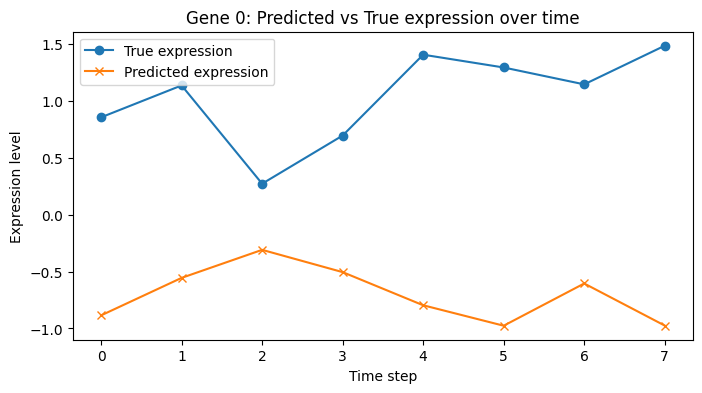

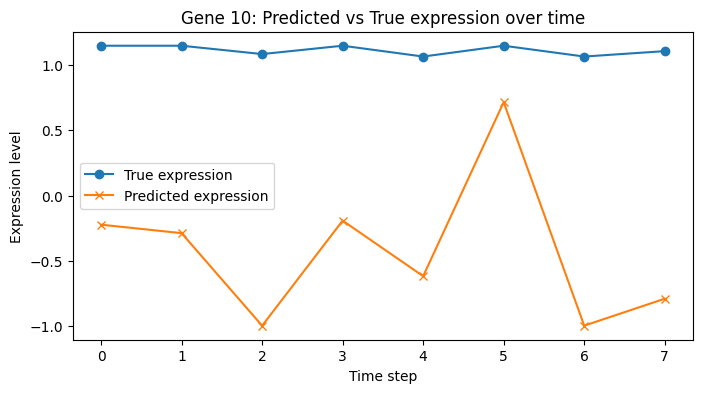

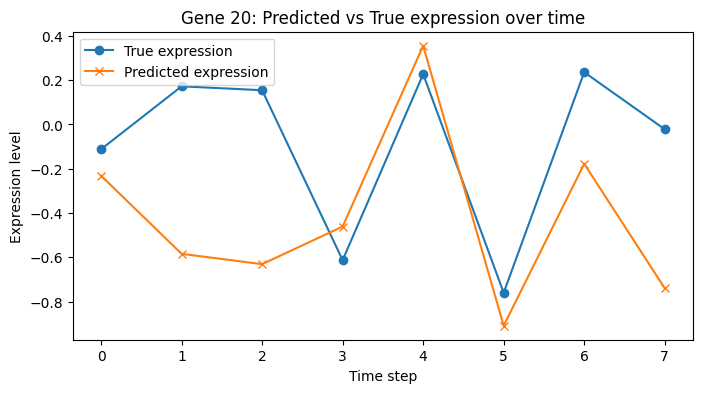

In [490]:
gene_indices = [0, 10, 20]  # change numbers as you like

time_points = np.arange(all_preds_np.shape[0])  # x-axis is sample index (time steps)

for idx in gene_indices:
    plt.figure(figsize=(8,4))
    plt.plot(time_points, all_trues_np[:, idx], label='True expression', marker='o')
    plt.plot(time_points, all_preds_np[:, idx], label='Predicted expression', marker='x')
    plt.title(f"Gene {idx}: Predicted vs True expression over time")
    plt.xlabel("Time step")
    plt.ylabel("Expression level")
    plt.legend()
    plt.show()

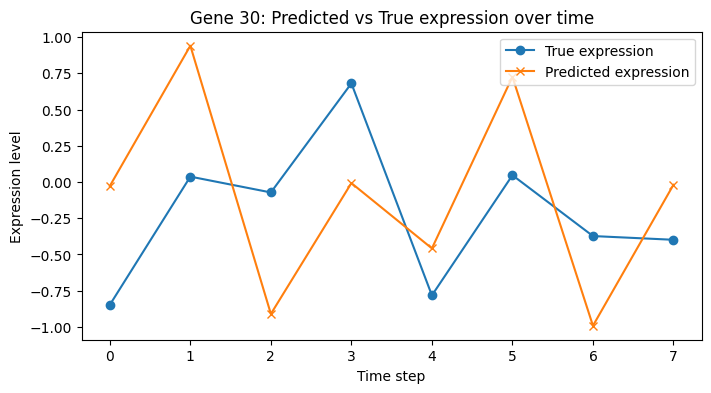

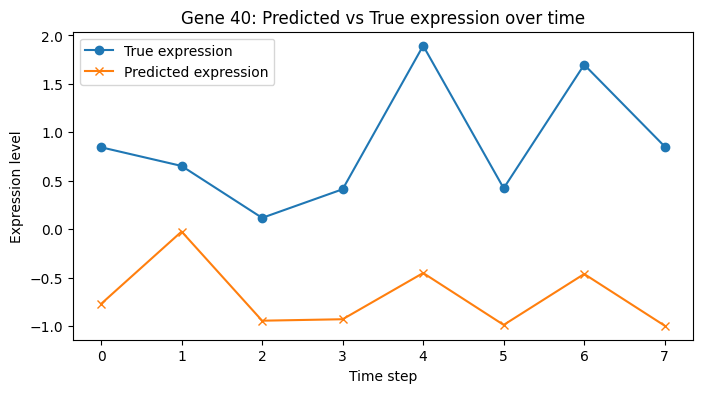

IndexError: index 50 is out of bounds for axis 1 with size 50

<Figure size 800x400 with 0 Axes>

In [491]:
gene_indices = [30, 40, 50]

time_points = np.arange(all_preds_np.shape[0])

for idx in gene_indices:
    plt.figure(figsize=(8,4))
    plt.plot(time_points, all_trues_np[:, idx], label='True expression', marker='o')
    plt.plot(time_points, all_preds_np[:, idx], label='Predicted expression', marker='x')
    plt.title(f"Gene {idx}: Predicted vs True expression over time")
    plt.xlabel("Time step")
    plt.ylabel("Expression level")
    plt.legend()
    plt.show()

In [492]:
if all_preds_np.ndim == 3:
    print(f"I am here!")
    all_preds_np = all_preds_np.squeeze(-1)
if all_trues_np.ndim == 3:
    all_trues_np = all_trues_np.squeeze(-1)

print("all_preds_np shape:", all_preds_np.shape)
print("all_trues_np shape:", all_trues_np.shape)

pearsons_per_node = []
spearmans_per_node = []

num_nodes = all_preds_np.shape[1]

for node_idx in range(num_nodes):
    pred_series = all_preds_np[:, node_idx]
    true_series = all_trues_np[:, node_idx]

    #print(f"Node {node_idx}: pred_series shape: {pred_series.shape}, true_series shape: {true_series.shape}")

    if np.std(pred_series) == 0 or np.std(true_series) == 0:
        continue

    p_corr, _ = pearsonr(pred_series, true_series)
    s_corr, _ = spearmanr(pred_series, true_series)

    pearsons_per_node.append(p_corr)
    spearmans_per_node.append(s_corr)

mean_pearson = np.mean(pearsons_per_node)
mean_spearman = np.mean(spearmans_per_node)

print(f"Mean Pearson correlation over genes: {mean_pearson:.4f}")
print(f"Mean Spearman correlation over genes: {mean_spearman:.4f}")


all_preds_np shape: (8, 50)
all_trues_np shape: (8, 50)
Mean Pearson correlation over genes: 0.0541
Mean Spearman correlation over genes: 0.0852


In [134]:
all_preds = []
all_trues = []

with torch.no_grad():
    for i, snapshot in enumerate(test_dataset):
        x = snapshot.x.clone().detach().float().to(device).squeeze(-1)  # (num_nodes, seq_len)
        y = snapshot.y.clone().detach().float().to(device)
        if y.dim() == 3:
            y = y.squeeze(-1)  # (num_nodes, pred_len)
        elif y.dim() == 1:
            y = y
        else:
            print(f"Warning: unexpected target shape {y.shape} at sample {i}")

        edge_index = snapshot.edge_index.to(device)
        if hasattr(snapshot, 'edge_weight') and snapshot.edge_weight is not None:
            edge_weight = snapshot.edge_weight.to(device)
        else:
            edge_weight = torch.ones(edge_index.size(1), device=device)

        pred = model(x, edge_index, edge_weight)  # predicted shape?

        print(f"Sample {i}: pred shape {pred.shape}, target shape {y.shape}")

        # Make sure pred and y have compatible shapes
        if pred.shape != y.shape:
            print(f"Shape mismatch at sample {i}: pred {pred.shape} vs target {y.shape}")
            continue  # skip this sample or handle appropriately

        all_preds.append(pred.cpu().numpy())
        all_trues.append(y.cpu().numpy())

all_preds = np.array(all_preds)
all_trues = np.array(all_trues)
print(f"Final all_preds shape: {all_preds.shape}, all_trues shape: {all_trues.shape}")

Sample 0: pred shape torch.Size([162, 1]), target shape torch.Size([162, 1])
Sample 1: pred shape torch.Size([162, 1]), target shape torch.Size([162, 1])
Sample 2: pred shape torch.Size([162, 1]), target shape torch.Size([162, 1])
Sample 3: pred shape torch.Size([162, 1]), target shape torch.Size([162, 1])
Sample 4: pred shape torch.Size([162, 1]), target shape torch.Size([162, 1])
Sample 5: pred shape torch.Size([162, 1]), target shape torch.Size([162, 1])
Sample 6: pred shape torch.Size([162, 1]), target shape torch.Size([162, 1])
Sample 7: pred shape torch.Size([162, 1]), target shape torch.Size([162, 1])
Sample 8: pred shape torch.Size([162, 1]), target shape torch.Size([162, 1])
Sample 9: pred shape torch.Size([162, 1]), target shape torch.Size([162, 1])
Sample 10: pred shape torch.Size([162, 1]), target shape torch.Size([162, 1])
Sample 11: pred shape torch.Size([162, 1]), target shape torch.Size([162, 1])
Sample 12: pred shape torch.Size([162, 1]), target shape torch.Size([162, 